**Reinforcement Learning for Stock Trading with OpenAI Gym AnyTrading**

In [ ]:
# Package installations and library imports
!pip install gym-anytrading stable-baselines3

import gymnasium as gym
import gym_anytrading
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from gym import envs
from gym_anytrading.envs import TradingEnv, ForexEnv, StocksEnv, Actions, Positions
from gym_anytrading.datasets import FOREX_EURUSD_1H_ASK, STOCKS_GOOGL
from stable_baselines3 import DQN
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.evaluation import evaluate_policy


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.2/172.2 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.3/182.3 kB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 23.5 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-ma

In [ ]:
# Debugging: Check if environment is registered
env_specs = envs.registry.all()
env_ids = [env_spec.id for env_spec in env_specs]

print(env_ids)  # We verify that 'stocks-v0' is listed

['CartPole-v0', 'CartPole-v1', 'MountainCar-v0', 'MountainCarContinuous-v0', 'Pendulum-v1', 'Acrobot-v1', 'LunarLander-v2', 'LunarLanderContinuous-v2', 'BipedalWalker-v3', 'BipedalWalkerHardcore-v3', 'CarRacing-v2', 'Blackjack-v1', 'FrozenLake-v1', 'FrozenLake8x8-v1', 'CliffWalking-v0', 'Taxi-v3', 'Reacher-v2', 'Reacher-v4', 'Pusher-v2', 'Pusher-v4', 'InvertedPendulum-v2', 'InvertedPendulum-v4', 'InvertedDoublePendulum-v2', 'InvertedDoublePendulum-v4', 'HalfCheetah-v2', 'HalfCheetah-v3', 'HalfCheetah-v4', 'Hopper-v2', 'Hopper-v3', 'Hopper-v4', 'Swimmer-v2', 'Swimmer-v3', 'Swimmer-v4', 'Walker2d-v2', 'Walker2d-v3', 'Walker2d-v4', 'Ant-v2', 'Ant-v3', 'Ant-v4', 'Humanoid-v2', 'Humanoid-v3', 'Humanoid-v4', 'HumanoidStandup-v2', 'HumanoidStandup-v4']


/usr/local/lib/python3.10/dist-packages/gym/envs/registration.py:421: UserWarning: WARN: The `registry.all` method is deprecated. Please use `registry.values` instead.
  logger.warn(


In [ ]:
# Initialize AnyTrading environment
env = gym.make('stocks-v0')

In [ ]:
# Object-oriented programming
class MyStocksEnv(StocksEnv):
    def __init__(self, prices, signal_features, **kwargs):
        self._prices = prices
        self._signal_features = signal_features
        super().__init__(**kwargs)

    def _process_data(self):
        return self._prices, self._signal_features


def my_process_data(df, window_size, frame_bound):
    start = frame_bound[0] - window_size
    end = frame_bound[1]
    prices = df.loc[:, 'Low'].to_numpy()[start:end]
    signal_features = df.loc[:, ['Close', 'Open', 'High', 'Low']].to_numpy()[start:end]
    return prices, signal_features

In [ ]:
prices, signal_features = my_process_data(df=STOCKS_GOOGL, window_size=30, frame_bound=(30, len(STOCKS_GOOGL)))
env = MyStocksEnv(prices, signal_features, df=STOCKS_GOOGL, window_size=30, frame_bound=(30, len(STOCKS_GOOGL)))

In [ ]:
# Naive baseline strategy (simple moving average)
def simple_moving_average(data, window=50):
    data['SMA'] = data['Close'].rolling(window=window).mean()
    data['Signal'] = 0
    data['Signal'][window:] = np.where(data['Close'][window:] > data['SMA'][window:], 1, 0)
    data['Position'] = data['Signal'].diff()
    return data

In [ ]:
sma_data = simple_moving_average(STOCKS_GOOGL)

<ipython-input-123-b89502431d24>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Signal'][window:] = np.where(data['Close'][window:] > data['SMA'][window:], 1, 0)


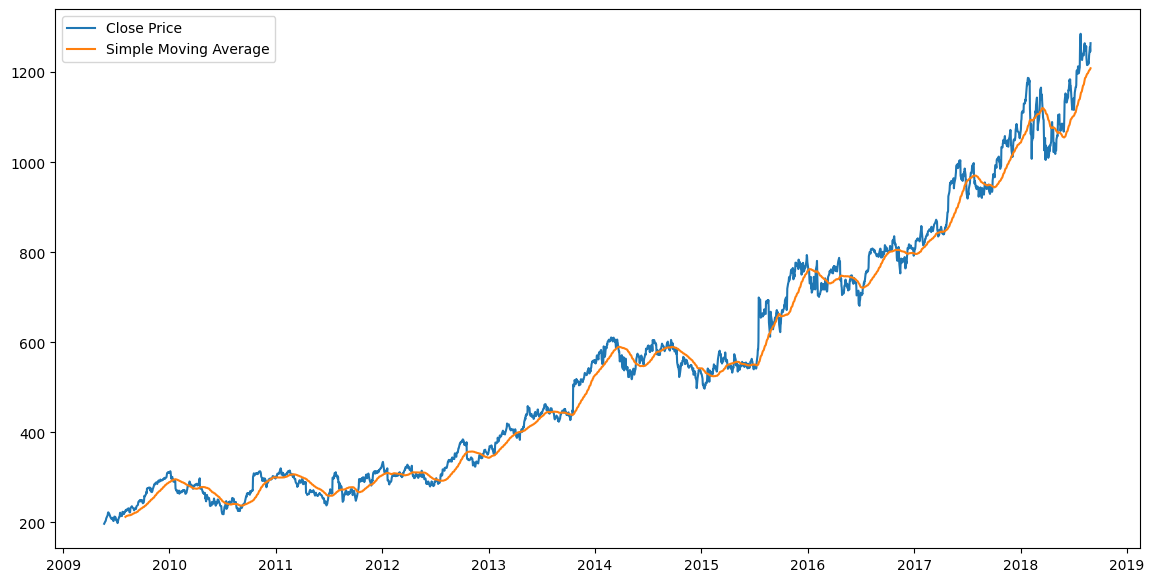

In [ ]:
# Plotting the SMA
plt.figure(figsize=(14, 7))
plt.plot(sma_data['Close'], label='Close Price')
plt.plot(sma_data['SMA'], label='Simple Moving Average')
plt.legend(loc='best')
plt.show()

In [ ]:
# Initialize environment with preprocessed data
env = gym.make('stocks-v0', df=sma_data)

In [ ]:
# Basic DQN algorithm
env = DummyVecEnv([lambda: env])
model = DQN('MlpPolicy', env, verbose=1)
model.learn(total_timesteps=10000)

Using cpu device
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4        |
|    fps              | 736      |
|    time_elapsed     | 12       |
|    total_timesteps  | 9216     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.805    |
|    n_updates        | 2278     |
----------------------------------


In [ ]:
# Evaluate and save the trained model
mean_reward, std_reward = evaluate_policy(model, env, n_eval_episodes=10)
print(f"Mean reward: {mean_reward}, Std reward: {std_reward}")

model.save("dqn_stock_trading")

/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Mean reward: 732.6669769287109, Std reward: 0.0


In [ ]:
# Initialize lists to store simulation data
observations = []
actions = []
rewards = []
portfolio_values = []

# Reset the environment, then initialize observations and portfolio_value
obs = env.reset()
observations.append(obs)
portfolio_value = 10000  # We first try initial portfolio value of $10,000
portfolio_values.append(portfolio_value)

for i in range(len(sma_data)):
    # Predict action given model and observation
    action, _states = model.predict(obs)
    actions.append(action)
    obs, reward, done, info = env.step(action)  # Take action in the environment

    # Store observation, reward, and portfolio value
    observations.append(obs)
    rewards.append(reward)
    portfolio_value = info[0]
    portfolio_values.append(portfolio_value['total_reward'])  # Use 'total_profit' key

    if done:
        break

# Convert lists to numpy arrays for consistency
observations = np.array(observations)
actions = np.array(actions)
rewards = np.array(rewards)
portfolio_values = np.array(portfolio_values)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


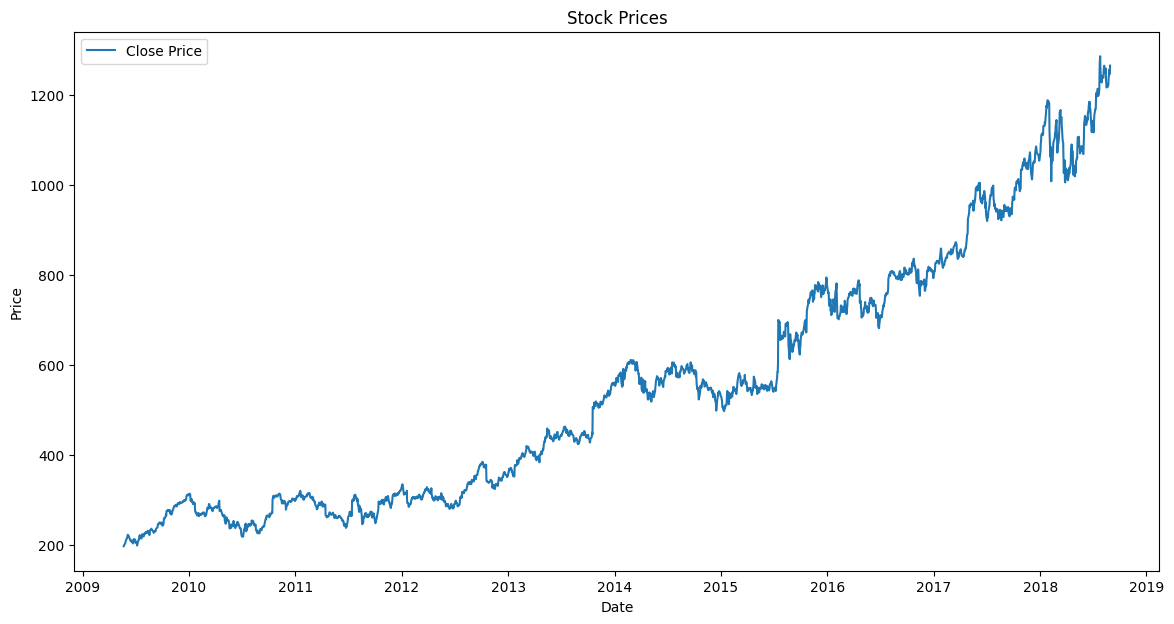

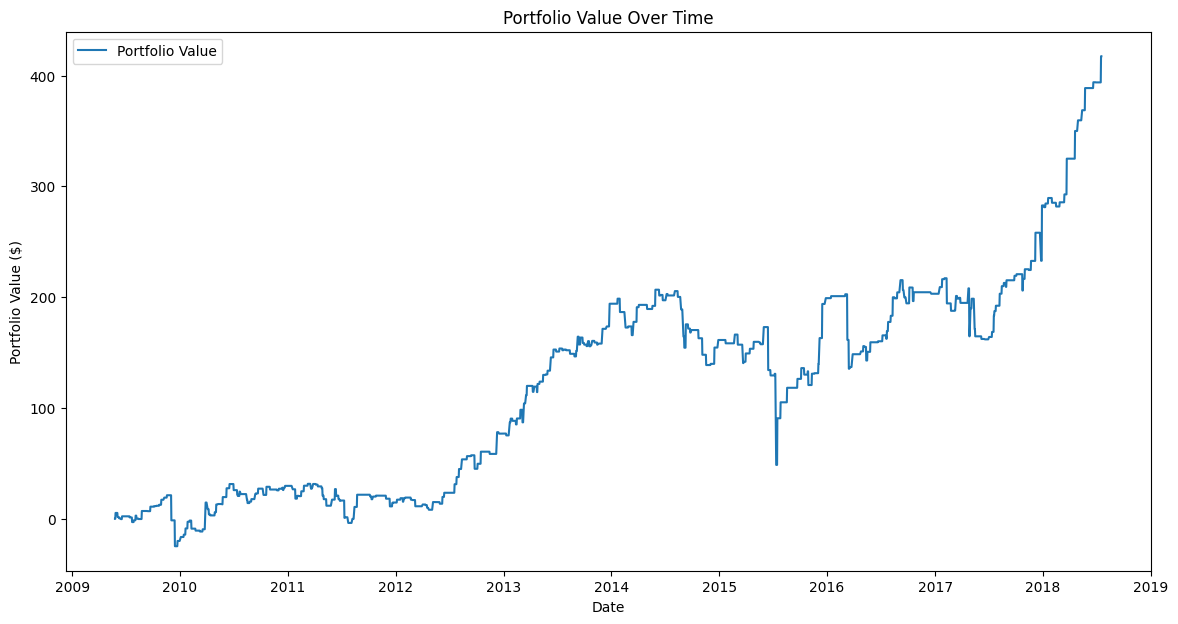

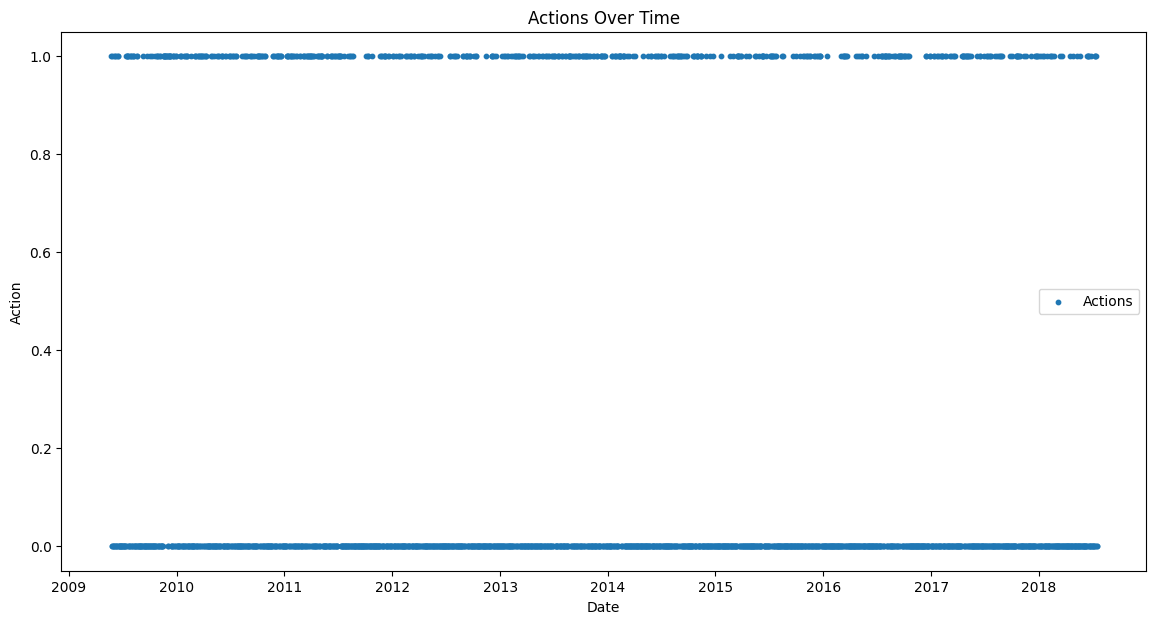

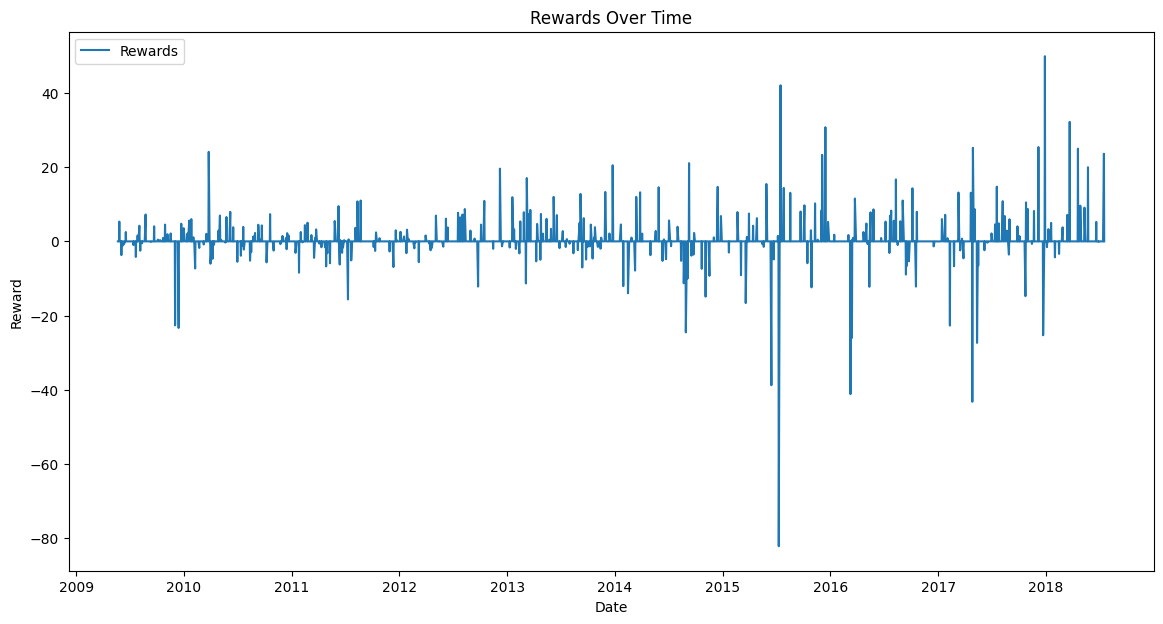

In [ ]:
# Load our stock data of choice
data = STOCKS_GOOGL

# Plot stock prices
plt.figure(figsize=(14, 7))
plt.plot(data.index, data['Close'], label='Close Price')
plt.title('Stock Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

# Plot portfolio value vs. time
plt.figure(figsize=(14, 7))
plt.plot(data.index[1:len(portfolio_values)], portfolio_values[1:], label='Portfolio Value')
plt.title('Portfolio Value Over Time')
plt.xlabel('Date')
plt.ylabel('Portfolio Value ($)')
plt.legend()
plt.show()

# Plot actions vs. time
plt.figure(figsize=(14, 7))
plt.scatter(data.index[:len(actions)], actions, s=10, label='Actions')
plt.title('Actions Over Time')
plt.xlabel('Date')
plt.ylabel('Action')
plt.legend()
plt.show()

# Plot rewards vs. time
plt.figure(figsize=(14, 7))
plt.plot(data.index[:len(rewards)], rewards, label='Rewards')
plt.title('Rewards Over Time')
plt.xlabel('Date')
plt.ylabel('Reward')
plt.legend()
plt.show()

In [ ]:
'''
Programming the Advantage Actor Critic (A2C) model, a REINFORCE-like algorithm.
'''

from stable_baselines3 import A2C

# Initialize
a2c_model = A2C('MlpPolicy', env, verbose=1)

# Train and save the model
a2c_model.learn(total_timesteps=50000)
a2c_model.save("a2c_stock_trading")

# Evaluate the model
mean_reward, std_reward = evaluate_policy(a2c_model, env, n_eval_episodes=10)
print(f"A2C Mean reward: {mean_reward}, Std reward: {std_reward}")

Using cpu device
------------------------------------
| time/                 |          |
|    fps                | 159      |
|    iterations         | 100      |
|    time_elapsed       | 3        |
|    total_timesteps    | 500      |
| train/                |          |
|    entropy_loss       | -0.567   |
|    explained_variance | 1.79e-07 |
|    learning_rate      | 0.0007   |
|    n_updates          | 99       |
|    policy_loss        | -3.7     |
|    value_loss         | 53.4     |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 244      |
|    iterations         | 200      |
|    time_elapsed       | 4        |
|    total_timesteps    | 1000     |
| train/                |          |
|    entropy_loss       | -0.692   |
|    explained_variance | 0        |
|    learning_rate      | 0.0007   |
|    n_updates          | 199      |
|    policy_loss        | 7.71     |
|    value_loss      

/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


A2C (REINFORCE-like) Mean reward: 0.0, Std reward: 0.0


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


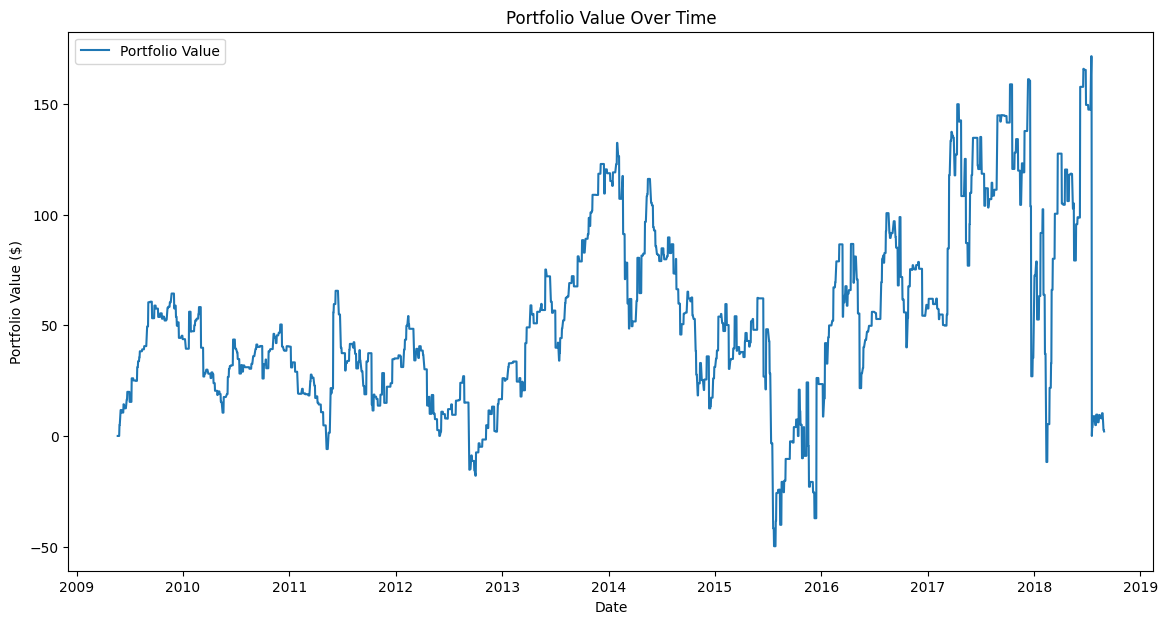

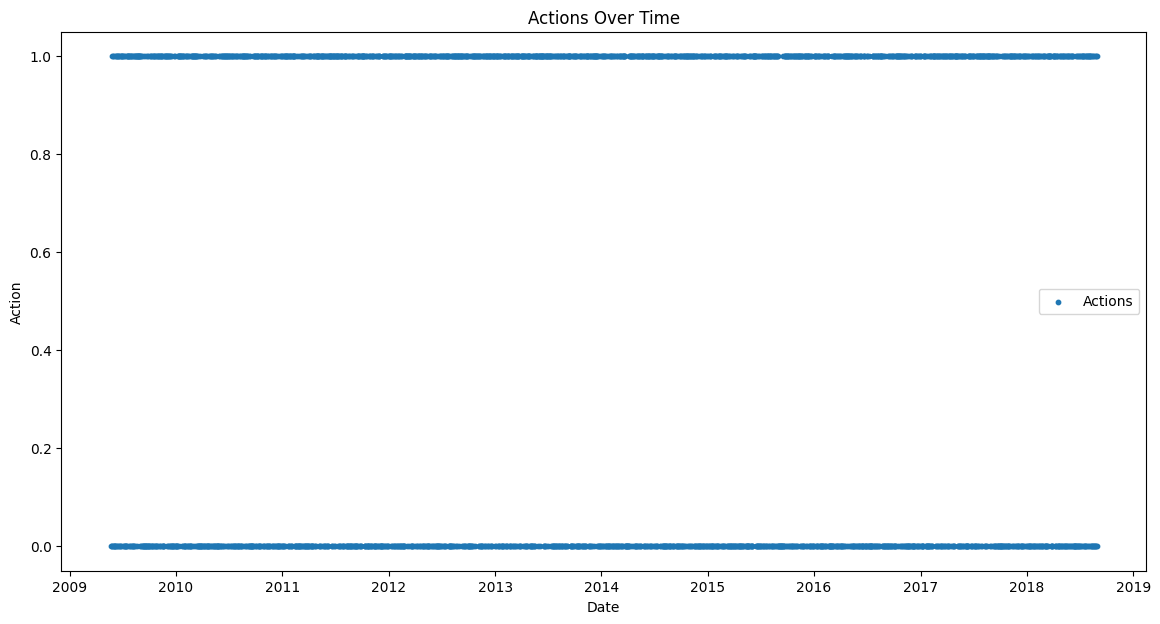

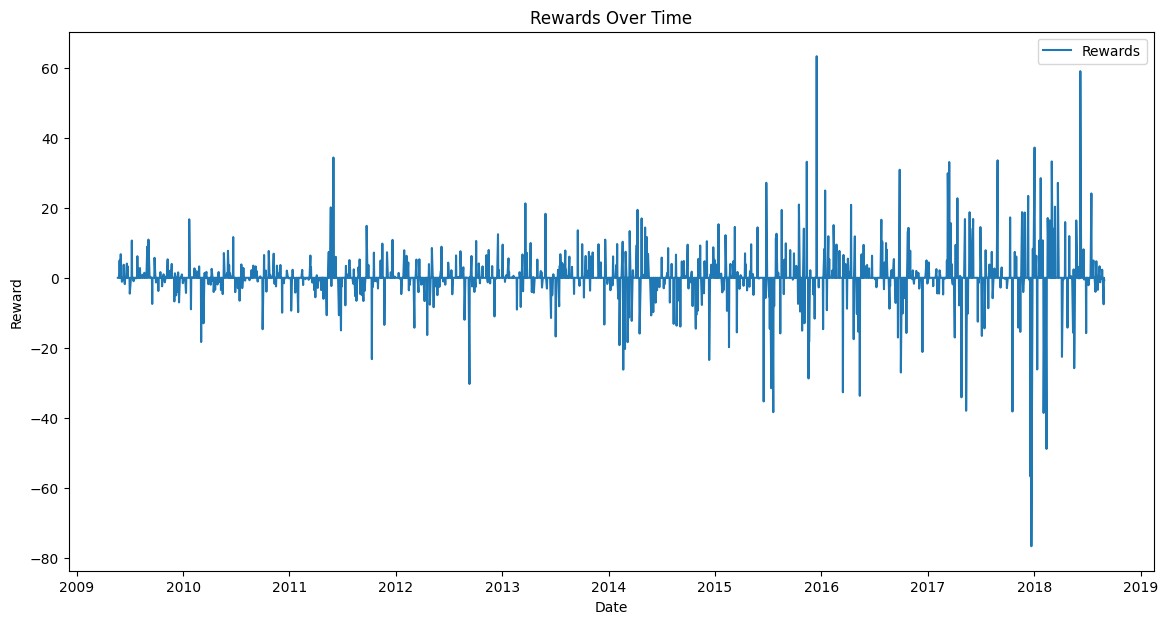

In [ ]:
# Initialize lists to store simulation data
observations = []
actions = []
rewards = []
portfolio_values = []

# Reset the environment
obs = env.reset()
observations.append(obs)
portfolio_value = 10000  # We try an initial portfolio value of $10,000
portfolio_values.append(portfolio_value)

for i in range(len(data)):
    # Predict action given model and observation
    action, _states = a2c_model.predict(obs)
    actions.append(action)

    # Take action in the environment, then store observation and reward
    obs, reward, done, info = env.step(action)
    observations.append(obs)
    rewards.append(reward)

    portfolio_value = info[0]
    portfolio_values.append(portfolio_value['total_reward'])  # Key: 'total_profit'

    if done:
        obs = env.reset()

# Convert lists to numpy arrays for consistency
observations = np.array(observations)
actions = np.array(actions)
rewards = np.array(rewards)
portfolio_values = np.array(portfolio_values)

In [ ]:
# Plot portfolio value vs. time
plt.figure(figsize=(14, 7))
plt.plot(data.index[:len(portfolio_values)], portfolio_values[1:len(portfolio_values)], label='Portfolio Value')
plt.title('Portfolio Value Over Time')
plt.xlabel('Date')
plt.ylabel('Portfolio Value ($)')
plt.legend()
plt.show()

# Plot actions vs. time
plt.figure(figsize=(14, 7))
plt.scatter(data.index[:len(actions)], actions, s=10, label='Actions')
plt.title('Actions Over Time')
plt.xlabel('Date')
plt.ylabel('Action')
plt.legend()
plt.show()

# Plot rewards vs. time
plt.figure(figsize=(14, 7))
plt.plot(data.index[:len(rewards)], rewards, label='Rewards')
plt.title('Rewards Over Time')
plt.xlabel('Date')
plt.ylabel('Reward')
plt.legend()
plt.show()

In [ ]:
'''
We calculate daily returns of the portfolio.
Assume an annual risk-free rate of 1% and 250 trading days in a year.
'''
epsilon = 0.00001  # Small (convergent) value for epsilon to avoid divide-by-zero
portfolio_returns = np.diff(portfolio_values) / (portfolio_values[:-1] + epsilon)

risk_free_rate = 0.01 / 250
excess_returns = portfolio_returns - risk_free_rate

# Calculate and display the Sharpe ratio
sharpe_ratio = np.mean(excess_returns) / np.std(excess_returns)
print(f"Sharpe Ratio: {sharpe_ratio}")


Sharpe Ratio: 0.02907420067401637
